# RO47002 Machine Learning for Robotics
* (c) TU Delft, 2023
* Period: 2023-2024, Q1
* Course homepage: https://brightspace.tudelft.nl/d2l/home/597271

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [1]:
GROUP_NUMBER = "74"
STUDENT_NAME1 = "Kevin Tran"
STUDENT_NUMBER1 = "4904672"
STUDENT_NAME2 = "Dielof van loon"
STUDENT_NUMBER2 = "5346894"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert(GROUP_NUMBER != "")
assert(STUDENT_NAME1 != "")
assert(STUDENT_NUMBER1 != "")
assert(STUDENT_NAME2 != "")
assert(STUDENT_NUMBER2 != "")

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you and your lab partner alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled practicum hours to ask a TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

---

# Practicum 2
* Topic: data collection & annotation, feature extraction, model exploration, visualization
* Before performing this practicum, work through **Book chapter(s): 2, 3**
* **Deadline**: Monday, September 18, 2023, 23:59

## Objectives
In this practicum, you and your lab partner will experiment with data collection, annotation, and turning a simple computer vision task into a machine learning problem.
This practicum will not go very deep in machine learning theory, but is more intended to make you familiar with the broader context of how machine learning can be applied in robotics, and experience some practical steps in performing your own data collection.
You will also demonstrate that you can perform several basic tasks with sklearn which have been explained in the book chapters.


The assignment is roughly organised into the steps of the "Machine Learning Project Checklist" explained in *Chapter 2 and Appendix B of the book*:

1. [Framing the problem](#framing_the_problem)
2. [Get the data](#get_the_data)
3. [Explore the data](#explore_the_data)
4. [Prepare the data](#prepare_the_data)
5. [Explore different models](#explore_different_models)
6. [Fine-tune your models](#fine_tune_your_models)
7. [Present your solution](#present_your_solution)
8. [Launch, monitor, and maintain your system](#maintain_your_system)

Of course, there are many more decisions and variations that could be explored at each step, but we will keep it simple for this exercise, so do not take this assignment as an exact template of what should or should not be done in each step. In real life, you would probably also move back and forward between these steps, revising some earlier decisions as you gain more insight on the problem. Nevertheless, this practicum provides a good guideline of how to approach such a task.

<a id='framing_the_problem'></a>
# 1. Framing the problem
The context of this practicum is of a robot which will need to be able to pickup a pen from a desk or table. The robot has a basic down-facing camera that it can place on top of the desk to inspect an area of interest.
The goal is to detect within this area where the pen is located, and how it is oriented.
To train the robot's perception system, we obtain a "pen image dataset" where the pen's extents (the physical tip and end) have been manually annotated in each image.
When the robot is deployed (a.k.a. *test* time), the robot will have to determine the locations of the tip and end of a pen in front of its camera.

How can we design a system that takes an image as input, and outputs the location and orientation of the pen?
We might consider two approaches:

* **Formulate this as a _regression_ problem:** Given an image, convert the full image to some feature representation and train a regressor that outputs 4 values, namely the (x,y) image locations of the tip, and the (x,y) locations of the end of the pen.

* **Formulate this as a _classification_ problem:** Divide the given image into small image patches. For each patch in the image, classifiy if this patch is the tip (start) of the pen, the end of the pen, the middle of the pen, or if it is just background. If we could succesfully classify patches at a diverse set of locations in the image, we would could determine the most probable image locations where the pen starts and ends, and thus its shape and orientation relative to the camera.

While the regression formulation might seem more natural, processing many local image regions in parallel is a more common practice in many machine learning for computer vision applications. The classification formulation could for instance be extended to work with images containing multiple pens, which simply ammounts to more image patches containing a tip, end or middle section, so the input and output space of the learned hypothesis function remains the same. In contrast, for regression we would need to change the output space to 8 values (namely four (x,y) coordinates) if we want to deal with two pens, thus changing the structure of the hypothesis function compared to the single pen case. Each different number of pens would thus require a different hypothesis function if we apply regression naively this way.

We therefore follow the **classification** approach in this assignment.

With this information our robot should have enough information to position and orient its (imaginary) grasper, and pick up the pen and put it in its pen collection.


![Robot holding a pen](extra/grasping-robot.jpg)
Image source: https://gigazine.net/gsc_news/en/20101221_robo_xero/


<div class="alert alert-info">
    <h1>🎥 <a href="https://brightspace.tudelft.nl/d2l/le/content/597271/viewContent/3314441/View">Lecture 2A - Case Study Visual Object Detection</a></h1>
    The following requires the knowledge covered in this lecture. If you haven't watched the video yet, it's now high time to do so...
</div>

### 1.1 Schematic Overview
Below you find a schematic overview of the intended way our robot should detect the position and orientation of the pen.
![Schematic overview of our approach](extra/schematic-prac2.jpg)

The main steps of the operational procedure in this figure are:
1. Take the input image, and extract smaller image patches around a diverse set of image location (shown as blue dots).
2. Once the patches are extracted, each patch is converted into some feature vector $x$.
3. The feature vectors are then fed to a trained classifier, which will assign to a patch one of four class labels:  background, tip of the pen, end of the pen, or middle of the pen.
4. After all patches in the image are classified, we post-process the result. Here we select the location of the patch for which the classifier is most confident that it belongs to the pen's tip, and the one for which it is most confident that it belongs to the pen's end. We assume the pen is located along the line connecting these points.

To built such a system, we thus first have to create a labelled dataset $X$ of image patches with the four class labels. With this dataset, we can select and optimise a suitable classifier. Other important choices are how many patches of each class we include in the training data, and how we represent each patch as a feature vector.

### 1.2 Setup common python stuff
We will start by loading a few common python dependencies

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, glob

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
import ipywidgets
from IPython.display import display

from collections import OrderedDict

In [5]:
import scipy
import skimage
import skimage.transform
import skimage.util

<a id='get_the_data'></a>
# 2. Get the data

For this assignment, you will first work on an annotated data set, consisting of annotated images of pens.
Let's make sure we can load the image and annotation data.

We start by listing the jpg files in the directory `images/mypen/`.
If everything is correct, we should find 37 jpg images.

In [6]:
import glob

def list_images(image_dir, filename_expression='*.jpg'):
    filenames = glob.glob(os.path.join(image_dir, filename_expression))
    filenames = sorted(filenames) # important for cross-platform compatiblity
    print(f'Found {len(filenames)} image files in the directory "{image_dir}"')
    return filenames

In [7]:
IMAGE_DIR = 'images/mypen'

# list all images. There should be 37 images in the images/mypen/ directory
filenames = list_images(IMAGE_DIR)
N = len(filenames)

Found 37 image files in the directory "images/mypen"


Le's see if we can load the first image and visualize it to verify that it has been loaded correctly.

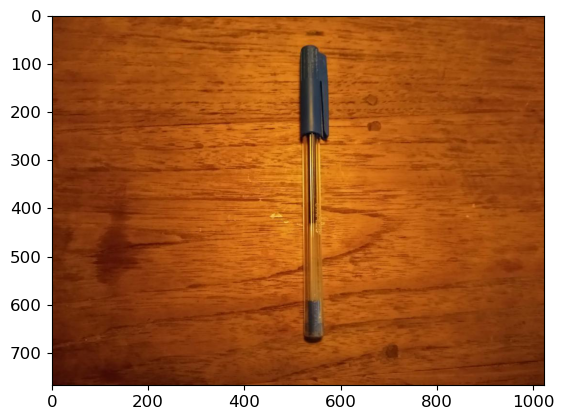

In [8]:
# Let's check if we can load and visualize an image here
I = plt.imread(filenames[0])
# this should show a picture of a pen
plt.figure()
plt.imshow(I)
plt.show()

To better understand how such image data is represented as a numpy array, let's start simple by creating 3 function to determine the width, height, and number of color channels of a loaded image. Channels would be 3 for a color image (Red, Green, Blue), and for instance 1 for a grayscale image.

Note that images are loaded as numpy matrices, and hence pixels are indexed similar as mathematical arrays, i.e. (row, column). This means that the first dimension of the image goes into the vertical direction, and the second dimension into the horizontal direction.

In [9]:
def get_image_width(I):
    return I.shape[1]

def get_image_height(I):
    return I.shape[0]

def get_image_channels(I):
    if len(I.shape) < 3:
        return 1
    return I.shape[2]

In [10]:
assert(get_image_width(I) == 1024)
assert(get_image_height(I) == 768)
assert(get_image_channels(I) == 3)

I2 = np.swapaxes(I, 0, 1) # swap the width and height, but keep the 3rd (color channel) dimension in place
assert(get_image_width(I2) == 768)
assert(get_image_height(I2) == 1024)
assert(get_image_channels(I2) == 3)


### 2.1 Load all images and annotations

Previously, we found all images in the given directory. Now we are going to load all of them. 

In [11]:
Is = [plt.imread(filename) for filename in filenames]
print('loaded %d images' % len(Is))

loaded 37 images


The data has been annotated by a human labeler manually clicking twice in each on image, such that the image coordinates of the first click indicate the location of the tip of the pen, and the second click of the end of the pen.
We can imagine a line between these locations, running along the length of the pen, such that image locations near the middle part of the line correspond to the center of the pen.

The annotations are therefore given as a $37 \times 4$ a matrix, where each $i$-th row contains the annotations of the $i-th$ image. A row contains for values, $(x_\textrm{tip},y_\textrm{tip},x_\textrm{end},y_\textrm{end})$, the image coordinates of the tip and end of the pen.

Using the standard python `pickle` or `numpy.load` module, load the data annotations which are stored as a numpy array in `annots.npy` which is stored in the same directory as the images. You can use the built-in function in `pickle` (doc: https://docs.python.org/3/library/pickle.html) or `numpy.load` function (doc: https://numpy.org/doc/stable/reference/generated/numpy.load.html).
If everything is correct, you will end up with a numpy array.

In [12]:
annots = None # store your solution in this variable
annot_filename = os.path.join(IMAGE_DIR, 'annots.npy')

annots = np.load(annot_filename, allow_pickle=True)


In [13]:
# if the annotations were correctly loaded, they should be a N x 4 numpy array
assert(annots is not None)
assert(type(annots) == np.ndarray)
assert(annots.shape == (37, 4))


### 2.2 Split the data into a train and test set

If everything is correct, you should now have loaded 37 images and their annotations. For the remainder of this exercises, we will now fix which labeled image data we shall consider as training data, and which for testing. We do this by simply storing the image indices of each split in a variable that we can use throughout the exercise.

- training data will consist of the first 26 images
- test data consists of the remaining 11 images

In [14]:
train_imgs = list(range(0,26))
test_imgs = list(range(26,len(Is)))

<a id='explore_the_data'></a>
# 3. Explore the data

Once we sucessfully loaded all images and annotations, we are now ready to implement a function to plot them. We can use `matplotlib.pyplot` (https://matplotlib.org/3.3.1/api/pyplot_summary.html) for this, which provides a very similar interface to the plotting commands found in Matlab.

In this plotting routine, you should execute the following steps:

1. show the image with `plt.imshow`, plot the following steps on top of the image
1. plot point p1 as a green circle with `plt.plot`, with markersize 10, and label "tip"
1. plot point p2 as a blue circle, with markersize 10, and label "end"
1. plot a yellow line starting at one point and ending at the other, give it linewdith 2 for more clarity
1. Add a legend with `plt.legend` (pro-tip: if you use the "label" keyword to the plot() commands to [simplify creating the legend](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html))

Use the matplotlib documentation to find basic usage information on these plotting routines.

In [15]:
def show_annotation(I, p1, p2):
    plt.figure()
    
    # show the image
    plt.imshow(I)
    # plot point p1 as a green circle, with markersize 10, and label "tip"
    plt.plot(p1[0], p1[1], 'go', markersize=10, label='tip')
    # plot point p2 as a blue circle, with markersize 10, and label "end"
    plt.plot(p2[0], p2[1], 'bo', markersize=10, label='end')
    # plot a yellow line starting at one point and ending at the other, give it linewdith 2 for more clarity
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'y', linewidth=2)
    # Use a suitable color and linewidth for better visualization
    # Add a legend (tip, you can use the "label" keyword when you plot a point)
    
    # done, show the image
    plt.show()

If everything is correct, this call to `show_annotation()` below should show a similar image as this reference:
![reference to first image](extra/reference_annotation.png)

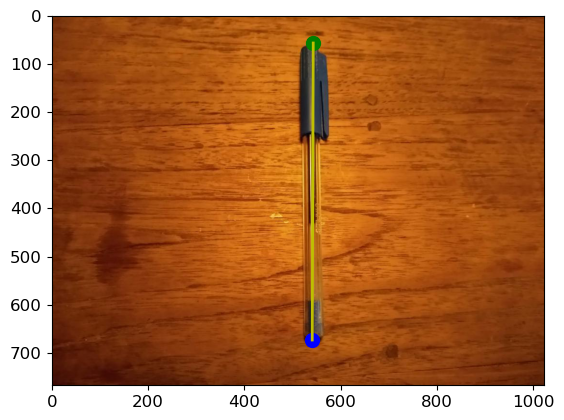

In [16]:
img_idx = 0
I = Is[img_idx]
p1 = annots[img_idx,:2].copy() # point 1, tip of the pen
p2 = annots[img_idx,2:].copy() # point 2, end of the pen

show_annotation(I, p1, p2)

Using jupyter's interactive widgets, we can now make a simple data explorer using a slider.

Using the powerful [`ipywidgets.interact`](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html#Basic-interact),
we can make a simple interactive widgets in a jupyter notebook to aid data exploration.
Note that every time we move the slide, `interact` we execute the plotting function that we gave it again, refreshing the plot.

In [17]:
def show_annotated_image(j):
    # show j-th training image
    img_idx = train_imgs[j]
    
    I = Is[img_idx]
    p1 = annots[img_idx,:2].copy() # point 1, tip of the pen
    p2 = annots[img_idx,2:].copy() # point 2, end of the pen

    show_annotation(I, p1, p2)

ipywidgets.interact(show_annotated_image, j=(0,len(train_imgs)-1))

interactive(children=(IntSlider(value=12, description='j', max=25), Output()), _dom_classes=('widget-interact'…

<function __main__.show_annotated_image(j)>

Use this stage to study your problem, and reflect on what types of variations are present (e.g. pen orientation?) or missing (e.g. different backgrounds?). You can also anticipate if there are any possible causes for noise or label errors.

<a id='prepare_the_data'></a>
# 4. Prepare the data

At this stage, we turn our images into a set $X$ of feature vectors with labels $y$ that can be used to train classifiers.
Remember that we somehow need to address the following issues here:
* How to select a useful and diverse set of patches from the images
* How to turn each image patch into a feature vector
* How to determine the class label for each patch, given we currently only have two annotated image locations (tip and end of pen)

### 4.1 Sample locations in image to extract patches

From each image we will extract multiple image patches, where each patch will be a small subregion of the image of $100 \times 100$ pixels.

Some of the patches will contain background, and others will contain parts of the pen.
Since most regions in the image contain background (the pen occupies only a relatively small part of the image), there is a risk that patches containing only background will be overrepresented in the training data. Such as *class inbalance* might result in our future classifier becoming *biased* to predict too many cases as background without considering the other classes, as that would result in a good training score.

We therefore will consider two strategies to sample patch locations from an image:

1. sample in a uniform grid across the image, which will have a lot of background patches,
2. sample some points similar to strategy 1, but also select additional points only around the pen

We'll also add some random offsets to the pixel coordinates of the sampled locations to add some more variance to the data,
and avoid accidentally having the exact same image location multiple times.

The code to implement these sampling strategies has already been given below.

In [18]:
# the size of the patch in pixels
WIN_SIZE = (100, 100, 3)

# for convenience, half the window
HALF_WIN_SIZE = (WIN_SIZE[0] // 2, WIN_SIZE[1] // 2, WIN_SIZE[2])

In [19]:
def sample_points_grid(I):
    # window centers
    W = get_image_width(I)
    H = get_image_height(I)
    
    step_size = (WIN_SIZE[0]//2, WIN_SIZE[1]//2)
    min_ys = range(0, H-WIN_SIZE[0]+1, step_size[0])
    min_xs = range(0, W-WIN_SIZE[1]+1, step_size[1])
    center_ys = range(HALF_WIN_SIZE[0], H-HALF_WIN_SIZE[0]+1, step_size[0])
    center_xs = range(HALF_WIN_SIZE[1], W-HALF_WIN_SIZE[1]+1, step_size[1])
    centers = np.array(np.meshgrid(center_xs, center_ys))
    centers = centers.reshape(2,-1).T
    centers = centers.astype(float) 
    
    # add a bit of random offset
    centers += np.random.rand(*centers.shape) * 10 
    
    # discard points close to border where we can't extract patches
    centers = remove_points_near_border(I, centers)
    
    return centers

def sample_points_around_pen(I, p1, p2):
    Nu = 100 # uniform samples (will mostly be background, and some non-background)
    Nt = 50 # samples at target locations, i.e. near start, end, and middle of pen
    
    target_std_dev = np.array(HALF_WIN_SIZE[:2])/3 # variance to add to locations

    upoints = sample_points_grid(I)
    idxs = np.random.choice(upoints.shape[0], Nu)
    upoints = upoints[idxs,:]
    
    
    # sample around target locations
    tpoints1 = np.random.randn(Nt,2)
    tpoints1 = tpoints1 * target_std_dev + p1

    tpoints2 = np.random.randn(Nt,2)
    tpoints2 = tpoints2 * target_std_dev + p2

    # sample over length pen
    alpha = np.random.rand(Nt)
    tpoints3 = p1[None,:] * alpha[:,None] + p2[None,:] * (1. - alpha[:,None])
    tpoints3 = tpoints3 + np.random.randn(Nt,2) * target_std_dev
    
    # merge all points
    points = np.vstack((upoints, tpoints1, tpoints2, tpoints3))
    
    # discard points close to border where we can't extract patches
    points = remove_points_near_border(I, points)
    
    return points

def remove_points_near_border(I, points):
    W = get_image_width(I)
    H = get_image_height(I)

    # discard points that are too close to border
    points = points[points[:,0] > HALF_WIN_SIZE[1],:]
    points = points[points[:,1] > HALF_WIN_SIZE[0],:]
    points = points[points[:,0] < W - HALF_WIN_SIZE[1],:]
    points = points[points[:,1] < H - HALF_WIN_SIZE[0],:]
    
    return points

The best way to understand the difference between these two sampling strategies is to visualize the locations of the center of the patches that they generate. In the figures below, each white dot indicates the center location of a patch.
You can see that strategy 2 would generate many more pathes containing parts of the pen.

Text(0.5, 1.0, 'sampling strategy 2')

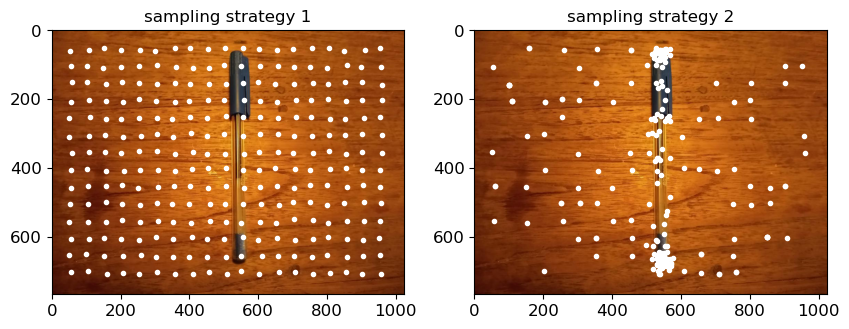

In [20]:
points1 = sample_points_grid(I) # sampling strategy 1
points2 = sample_points_around_pen(I, p1, p2) # sampling strategy 2

# plot both sampling strategies in a single figure using subplots
plt.figure(figsize=(10,12))
plt.subplot(1,2,1)
plt.imshow(I)
plt.plot(points1[:,0], points1[:,1], 'w.')
plt.title('sampling strategy 1')

plt.subplot(1,2,2)
plt.imshow(I)
plt.plot(points2[:,0], points2[:,1], 'w.')
plt.title('sampling strategy 2')

### 4.2 Extract patches at a target location

You will now write a hand-crafted feature extraction, a simple function of a few lines of code which:

- takes as first input `I`: the RGB input image 
- takes as second input `p`: a 2D location in pixel coordinates
- returns the $100 \times 100 \times 3$ image patch centered around pixel coordinates p

To extract an image patch, you can use array slicing as you learned in week 1.

Note that point p will be given as a 2-dimensional floating point numpy vector. You should cast the elements to `int` types before you can use them to slice an array.


In [21]:
def get_patch_at_point(I, p):
    p = [int(p[0]), int(p[1])]
    pl = p[1] - 50
    pr = p[1] + 50
    pu = p[0] - 50
    pd = p[0] + 50
    P = I[pl:pr, pu:pd, :]
    
    return P

To test your solution, let's extract the patch around the annotated tip of the pen. If everything is correct, you should be able to see the tip similar to this reference image: ![reference patch](extra/reference_patch.png)

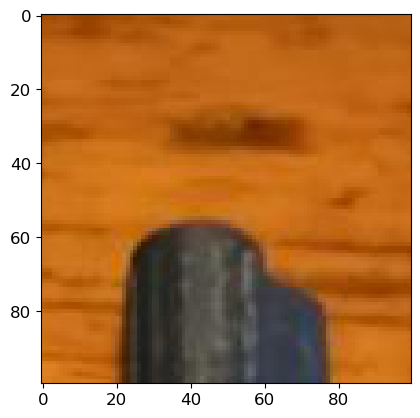

In [22]:
P = get_patch_at_point(I, p1)
plt.imshow(P)
plt.show()

assert(get_image_width(P) == 100)
assert(get_image_height(P) == 100)
assert(get_image_channels(P) == 3)

### 4.3 Determine the label of a patch

To determine the labels of a patch,
we'll consider the distance of the patch's center to the tip of the pen (class 1),
to the end of the pen (class 2), or to the middle of the pen (class 3).
We will assign the class label based on which distance is the shortest,
but only if this shortest distance is under a certain threshold since the pen should still be visible within the patch.
If the patch is too far away from the pen, we will mark it as background (class 0).

In [23]:
CLASS_NAMES = [
    'background', # class 0
    'tip',        # class 1
    'end',        # class 2
    'middle'      # class 3
]

def make_labels_for_points(I, p1, p2, points):
    """ Determine the class label (as an integer) on point distance to different parts of the pen """
    num_points = points.shape[0]
    
    # for all points ....
    
    # ... determine their distance to tip of the pen
    dist1 = points - p1
    dist1 = np.sqrt(np.sum(dist1 * dist1, axis=1))
    
    # ... determine their distance to end of the pen
    dist2 = points - p2
    dist2 = np.sqrt(np.sum(dist2 * dist2, axis=1))

    # ... determine distance to pen middle
    alpha = np.linspace(0.2, 0.8, 100)
    midpoints = p1[None,:] * alpha[:,None] + p2[None,:] * (1. - alpha[:,None]) 
    dist3 = scipy.spatial.distance_matrix(midpoints, points)
    dist3 = np.min(dist3, axis=0)
    
    # the class label of a point will be determined by which distance is smallest
    #    and if that distance is at least below `dist_thresh`, otherwise it is background
    dist_thresh = WIN_SIZE[0] * 2./3.

    # store distance to closest point in each class in columns
    class_dist = np.zeros((num_points, 4))
    class_dist[:,0] = dist_thresh
    class_dist[:,1] = dist1
    class_dist[:,2] = dist2
    class_dist[:,3] = dist3
    
    # the class label is now the column with the lowest number
    labels = np.argmin(class_dist, axis=1)
    
    return labels


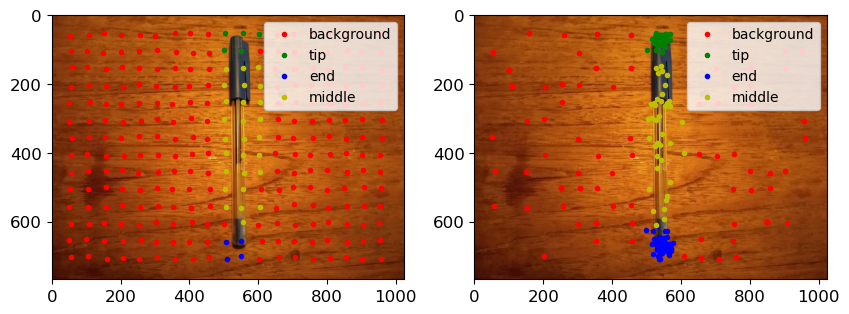

In [24]:
def plot_labeled_points(points, labels):
    plt.plot(points[labels == 0, 0], points[labels == 0, 1], 'r.', label=CLASS_NAMES[0])
    plt.plot(points[labels == 1, 0], points[labels == 1, 1], 'g.', label=CLASS_NAMES[1])
    plt.plot(points[labels == 2, 0], points[labels == 2, 1], 'b.', label=CLASS_NAMES[2])
    plt.plot(points[labels == 3, 0], points[labels == 3, 1], 'y.', label=CLASS_NAMES[3])

labels1 = make_labels_for_points(I, p1, p2, points1)
labels2 = make_labels_for_points(I, p1, p2, points2)

plt.figure(figsize=(10,12))

plt.subplot(1,2,1)
plt.imshow(I)
plot_labeled_points(points1, labels1)
plt.legend()

plt.subplot(1,2,2)
plt.imshow(I)
plot_labeled_points(points2, labels2)
plt.legend()

As can be seen in the images, the sampling strategies result in different amount of patches being extracted. In the first strategy, for instance, there are indeed many more "background" patches than in the second one.

Instead of only looking at images to get a "qualitative" feel of the data distribution, it would be good to also be able to quantify how (im)balanced these class distributions are.
We should therefore first determine the number of samples of each class in `labels1` and `labels2`.

Complete the function `count_classes(labels)` below, which for a given array of `labels` creates a 4-dimensional numpy vector, where the i-th element contains the number of times that class occurs in `labels`. We then use this to count each class occurs in the labels obtained with each strategy.

In [25]:
def count_classes(labels):
    counts = np.array([0]*4)
    for i in labels:
        counts[i] += 1
    return counts

In [26]:
assert(np.all(count_classes([3,0,2,3,1,0]) == [2,1,1,2])) # 2 zeros, 1 one, 1 two, 2 threes
assert(np.all(count_classes([3,2,1,2]) == [0,1,2,1])) # 0 zeros, 1 one, 2 twos, 1 three

# dtype of resulting array should be integer
cnt = count_classes([3,2,1,2])
assert(np.issubdtype(cnt.dtype, np.integer))


In [27]:
# use your count_classes function to determine how often each class labels occurs when using each strategy
class_counts1 = count_classes(labels1)
class_counts2 = count_classes(labels2)
print('class occurrences with strategy 1:', class_counts1)
print('class occurrences with strategy 2:', class_counts2)

class occurrences with strategy 1: [230   5   4  27]
class occurrences with strategy 2: [92 43 57 40]


It is clear from these numbers that in strategy 1 one class is very frequent, and the others much less so. With strategy 2, the classes are more uniformly distributed.

As an exercise, we can try to express the amount of 'uniformity' in a distribution using a key concept from information theory: *entropy*. This concept is also related to the concept of *cross-entropy* which you will learn about more later in the course. On YouTube you can find [a good video introduction on entropy and cross-entropy](https://www.youtube.com/watch?v=ErfnhcEV1O8).
For now, it suffices to state that entropy measures the amount of 'surprise' or 'uncertainty' we would have about the outcome if we would sample from a given distribution. For instance, if the distribution over the four classes would be so skewed that all samples belong to one class, the entropy would be 0 as there would be no surprise what class label we would see if we take a random sample.
On the other hand, the maximum entropy is achieved when all classes are completely equally likely to occur, i.e. the class labels would be uniformly distributed.

So, to compute the entropy of the class label counts of the two sampling strategies, first implement the following two functions:
1. a function `class_probs(counts)` which takes the class occurence `counts`, and return a distribution vector $\boldsymbol{p} = [p_1, p_2, p_3, p_4]$ , i.e. a vector of the same length (number of classes), with elements $p_c \in [0,1]$ which sum up to 1, $\sum_c p_c = 1$. Each element $p_c$ represent the class probability $P(c)$ that a sample in the distribution has class label $c$.
2. an `entropy(p)` function which takes a class distribution vector `p`, and computes the entropy for that distribution. The formula will be given below.

Afterwards, you can compute the entropy of each strategy,
and compared to the theoretic maximum entropy for a perfectly uniform distribution over the four classes.

In [28]:
def class_probs(counts):
    p = [i/np.sum(counts) for i in counts]
    return p

In [29]:
# check uniform class distribution
test_dist_1 = np.array([0.25, 0.25, 0.25, 0.25])
assert(np.all(class_probs(np.array([1,1,1,1])) == test_dist_1))
assert(np.all(class_probs(np.array([100,100,100,100])) == test_dist_1))

# check non-uniform distributions
test_dist_2 = np.array([0., 1., 0., 0.])
assert(np.all(class_probs(np.array([0,42,0,0])) == test_dist_2))

test_dist_3 = np.array([0., 0.5, 0., 0.5])
assert(np.all(class_probs(np.array([0,1,0,1])) == test_dist_3))

# should sum up to one for any given of class counts
assert(np.sum(class_probs(np.array([36,20,9,412]))) == 1)
assert(np.all(class_probs(np.array([36,20,9,412]))) > 0.)

Now implement the [*entropy*](https://en.wikipedia.org/wiki/Entropy_(information_theory)) function:

$H = - \sum_c P(c) log_2(P(c)) $.

You can find this formula in many fields of science, such as physics, and different uses tend to use this equation with a different base for the logarithm (e.g. an obvious choice would be the natural logarithm with base $e$). We will here use Shannon's entropy from information theory using base 2. The entropy $H$ can then be interpreted as the expected number of bits of information that is needed to communicate the class label $c$ of a random sample from $P$. Again as an extreme, if all samples would have the same class label, there would be no "uncertainty", and no information needs to be communicated about the label of an arbitrary sample, corresponding to $H = 0$ bits of information. On the other hand, if you have 8 equally probable class labels and thus full uncertainty about the label of any random sample, you would be expected to communicate $H = 3$ bits of information to indicate which of the $2^3 = 8$ labels that particular sample has.

Note that this formula assumes that all classes have at least a non-zero chance of occurring, and you might run into numeric issues if $P(c) = 0$ for one or more classes $c$. The best thing to do is to remove any zero-probability classes if they occur.

For this exercise, you must implement this function yourself. You can numpy functions, but not any other statistical python packages.

In [30]:
def entropy(p):
    p = np.array(p)
    p = p[p != 0]
    H = -1 * np.sum([i * np.log2(i) for i in p])
    return H

In [31]:
# 1-class test case
#  (only one class distribution possible, no uncertainty on outcome)
assert(entropy(np.array([1.0])) == 0)

# 2-class cases
# For 2 classes, the entropy should always be between 0.0 and 1.0
assert(entropy(np.array([0.5, 0.5])) == 1.0) # a 50%-50% distribution requires 1 bit of information
assert(entropy(np.array([1.0, 0.0])) == 0.0) # a 100%-0% distribution requires 0 bits of information (no uncertainty)
# NOTE: if this test above doesn't work,
# you may still need to remove the elements with probability 0 from the input vector p

# 3-class test cases
# entropy of [0.1, 0.6, 0.3] is approx 1.2954618, slightly more than one bit of information
assert(np.abs(entropy(np.array([0.1, 0.6, 0.3])) - 1.2954618)<1e-4) 

In [32]:
ANSWER_STRATEGY1_ENTROPY = None # store your solution in this variable name
ANSWER_STRATEGY2_ENTROPY = None # store your solution in this variable name
ANSWER_MAX_FOUR_CLASS_ENTROPY = None # store your solution in this variable name

ANSWER_MAX_FOUR_CLASS_ENTROPY = entropy([0.25] * 4)
ANSWER_STRATEGY1_ENTROPY = entropy(class_probs(class_counts1))
ANSWER_STRATEGY2_ENTROPY = entropy(class_probs(class_counts2))

In [33]:
assert(ANSWER_STRATEGY1_ENTROPY is not None) # check to ensure the right variable name is used
assert(ANSWER_STRATEGY2_ENTROPY is not None) # check to ensure the right variable name is used
assert(ANSWER_MAX_FOUR_CLASS_ENTROPY is not None) # check to ensure the right variable name is used

print('Your computed results:')
print('          Entropy for labels in strategy 1:', ANSWER_STRATEGY1_ENTROPY)
print('          Entropy for labels in strategy 2:', ANSWER_STRATEGY2_ENTROPY)
print('Max. entropy for a four class distribution:', ANSWER_MAX_FOUR_CLASS_ENTROPY)


Your computed results:
          Entropy for labels in strategy 1: 0.7152286206513521
          Entropy for labels in strategy 2: 1.9146666028330888
Max. entropy for a four class distribution: 2.0


If everything is correct, the results you computed should confirm that the labels obtained with strategy 2 has an entropy close to the theoretic maximum, and thus is in an objective quantifiable sense more uniformly distribution than the class labels obtained with strategy 1.

We will revisit entropy in future lectures and (Book) exercises.

### 4.4 Transform patches into feature vectors

Now that we can create a dataset of labeled image patches (using either strategy 1 or 2), we focus on *feature extraction*, i.e. the transformation that converts each input patch into a fixed size feature vector for the classifier.
A good feature extractor ensures that the important variance in the data is kept and makes the classes easily separable. At the same time, it should also suppress unimportant variations and noise in the data, especially if the amount of training data is limited, since then the classifier will not have to *learn* that such variations should not affect the outcome.



<div class="alert alert-info">
    <h1>🎥 <a href="https://brightspace.tudelft.nl/d2l/le/content/597271/viewContent/3314443/View">Lecture 2B - ML Formalized (part2)</a></h1>
    The following requires the knowledge covered in this lecture. If you haven't watched the video yet, it's now high time to do so...
</div>

Here you will implement a very simple strategy as the function `patch_to_vec`, which takes an image patch as input, and should return its feature representation, a vector $x$.
The function should do the following:

1. Resize the patch to a $9 \times 9 \times 3$ color image. To resize the image (patch), `skimage.transform` might contain a useful function, check the documentation here: https://scikit-image.org/docs/dev/api/skimage.transform.html. Note that we do not want to use any anti_aliasing features, since these are slow and we need to convert many patches.

2. After downsizing the patch, reshape or flatten the patch (which is a 3-dimensional [tensor](https://nl.wikipedia.org/wiki/Tensor)) to a vector (i.e. a 1-dimensional tensor).

In [34]:
# the target size of the patches after downsizing
FEAT_SIZE = (9,9,3)

In [35]:
def patch_to_vec(P):
    x = skimage.transform.downscale_local_mean(P, (12, 12, 1))
    x = x.flatten()
    return x

**Q:** How many dimensions will the resulting feature space have?

In [36]:
number_of_feature_dimensions = None # store your solution in this variable name

number_of_feature_dimensions = len(patch_to_vec(P))

assert(number_of_feature_dimensions is not None) # check to ensure the right variable name is used

print(f'This will be a {number_of_feature_dimensions}-dimensional feature space')

This will be a 243-dimensional feature space


In [37]:
assert number_of_feature_dimensions is not None

### 4.5 Let's put it all together

Finally, we put all the preceding steps together to construct our set of feature vectors from a given raw dataset of images. The following code performs the following steps:

* For each image in our dataset, do the following
    1. select patch locations, using one of the two strategies
    2. determine the class label for each location, considering the image annotations
    3. extract the image patches at the selected locations
    4. convert each image patches to a feature vector
* Concatenate all features and labels from the images together in one data matrix `X`, and one large label vector
* Also, for each feature vector we keep track in `imgids` from which image it was extracted, and in `points` at which pixel coordinate the patch was located. This will help us later to visualize the results.

In [38]:
def extract_patches(I, p1, p2, strategy=None):
    
    # by default, if no strategy is explicitly defined, use strategy 2
    if strategy == 1:
        points = sample_points_grid(I)
    if strategy == 2 or strategy is None:
        points = sample_points_around_pen(I, p1, p2)
    
    # determine the labels of the points
    labels = make_labels_for_points(I, p1, p2, points)
    
    xs = []
    for p in points:
        P = get_patch_at_point(I, p)
        x = patch_to_vec(P)
        xs.append(x)
    X = np.array(xs)

    return X, labels, points

def extract_multiple_images(Is, idxs, annots, strategy=None):
    Xs = []
    ys = []
    points = []
    imgids = []

    for step, idx in enumerate(idxs):
        I = Is[idx]
        I_X, I_y, I_points = extract_patches(I, annots[idx,:2], annots[idx,2:], strategy=strategy)

        classcounts = count_classes(I_y)
        print(f'image {idx}, class count = {classcounts}')

        Xs.append(I_X)
        ys.append(I_y)
        points.append(I_points)
        imgids.append(np.ones(len(I_y),dtype=int)*idx)

    Xs = np.vstack(Xs)
    ys = np.hstack(ys)
    points = np.vstack(points)
    imgids = np.hstack(imgids)
    
    return Xs, ys, points, imgids

In [39]:
X_train, y_train, points_train, imgids_train = extract_multiple_images(Is, train_imgs, annots)

image 0, class count = [90 36 52 51]
image 1, class count = [88 58 59 45]
image 2, class count = [91 54 54 51]
image 3, class count = [88 60 56 46]
image 4, class count = [82 54 58 56]
image 5, class count = [87 58 59 46]
image 6, class count = [89 57 58 46]
image 7, class count = [85 59 54 52]
image 8, class count = [85 63 60 41]
image 9, class count = [87 57 54 52]
image 10, class count = [75 57 58 60]
image 11, class count = [90 52 56 52]
image 12, class count = [88 59 59 44]
image 13, class count = [82  9 56 57]
image 14, class count = [84 56 61 49]
image 15, class count = [85 59 58 48]
image 16, class count = [85 57 55 53]
image 17, class count = [94 61 54 41]
image 18, class count = [83 58 28 54]
image 19, class count = [93 55 59 43]
image 20, class count = [89 56 53 52]
image 21, class count = [92 55 58 45]
image 22, class count = [91 56 56 47]
image 23, class count = [90 62 53 45]
image 24, class count = [89 58 62 41]
image 25, class count = [82 55 55 58]


In [40]:
X_test, y_test, points_test, imgids_test = extract_multiple_images(Is, test_imgs, annots)

image 26, class count = [88 55 60 47]
image 27, class count = [84 59 55 52]
image 28, class count = [91 54 56 49]
image 29, class count = [88 59 59 44]
image 30, class count = [83 59 56 52]
image 31, class count = [88 55 59 48]
image 32, class count = [87 54 53 56]
image 33, class count = [87 54 55 54]
image 34, class count = [93 57 57 43]
image 35, class count = [93 60 52 45]
image 36, class count = [86 60 55 49]


Finally, let's add a simple interactive ipython widget to quickly inspect the images, and the sampled locations.

In [41]:
def show_gt_labels(idx, Is, y_train, points_train, imgids_train):
    I = Is[idx]
    
    I_points = points_train[imgids_train == idx,:]
    I_ys = y_train[imgids_train == idx]

    plt.figure()
    plt.imshow(I)
    plot_labeled_points(I_points, I_ys)
    plt.legend()
    plt.show()

ipywidgets.interact(show_gt_labels, 
                    idx=(0,len(train_imgs)-1), 
                    Is = ipywidgets.fixed(Is), 
                    y_train = ipywidgets.fixed(y_train), 
                    points_train = ipywidgets.fixed(points_train), 
                    imgids_train = ipywidgets.fixed(imgids_train))

interactive(children=(IntSlider(value=12, description='idx', max=25), Output()), _dom_classes=('widget-interac…

<function __main__.show_gt_labels(idx, Is, y_train, points_train, imgids_train)>

We can also visualize the samples from each class

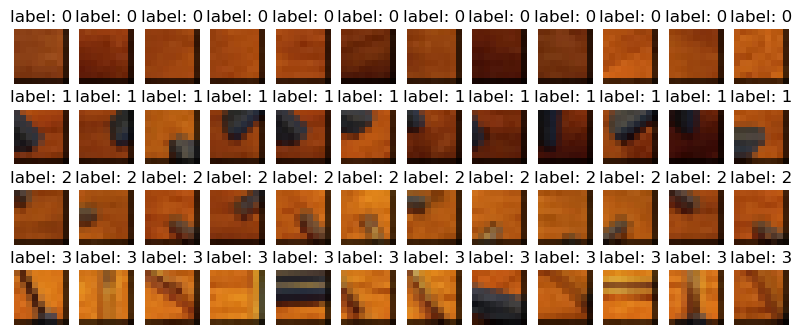

In [42]:
def plot_samples(Ps, labels):
    uls = np.unique(labels)
    nclasses = len(uls)
    nsamples = 12
    
    plt.figure(figsize=(10,4))
    
    for lidx, label in enumerate(uls):
        idxs = np.where(labels == label)[0]
        idxs = np.random.choice(idxs, nsamples, replace=False)
        
        for j, idx in enumerate(idxs):
            P = Ps[idx,:]
            P = P.reshape(FEAT_SIZE)
            plt.subplot(nclasses, nsamples, lidx*nsamples+j+1)
            plt.imshow(P.astype('uint8'), clim=(0,1))
            plt.axis('off')
            plt.title('label: %d' % label)
        
    plt.show()

plot_samples(X_train, y_train)

<a id='explore_different_models'></a>
# 5. Explore Different Models

We can now select some classifiers that we might want to test on this dataset.

* a *Logistic Regression classsifier* using the `SGDClassifier` class in the `linear_model` package of sklearn. See also Chapter 3 of the book. Call the classifier object `sgd_clf`. Look into the documentation of `SGDClassifier` to see how to set the loss to the logistic regression loss.
* a *Decision Tree* using `DecisionTreeClassifier`. Note that Chapter 2 used the related `DecisionTreeRegressor`, which uses a similar approach, but then for regression
* a *Random Forest* using `RandomForestClassifier`. See also Chapter 2.

You may need to import the relevant modules from `sklearn`.

PS.: Do NOT train the classifiers yet, we'll do that in a notebook cell below.

In [43]:
sgd_clf = None # store your solution in variable name
dt_clf = None # store your solution in variable name
rf_clf = None # store your solution in variable name

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

sgd_clf = SGDClassifier() # store your solution in variable name
dt_clf = DecisionTreeClassifier() # store your solution in variable name
rf_clf = RandomForestClassifier() # store your solution in variable name


In [44]:
assert(sgd_clf is not None) # check to ensure the right variable name is used
assert(dt_clf is not None) # check to ensure the right variable name is used
assert(rf_clf is not None) # check to ensure the right variable name is used 


Now train each of these classifiers on the training data `X_train` and `y_train`.

In [45]:
# Train the classifiers here

sgd_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
assert(sgd_clf.n_iter_ > 0) # NOTE: n_iter_ will not exist until training
assert(dt_clf.n_features_in_ > 0) # NOTE: n_features_in_ will not exist until training
assert(rf_clf.n_features_in_ > 0) # NOTE: n_features_in_ will not exist until training

### 5.1 Evaluation

We start evaluation by just focusing on the Logistic Regression, and see what the accuracy is on the **training data** on which it was optimized on.

In [47]:
# predict the class labels of the linear classifier on the training data

y_train_pred = None # store your solution in variable name

y_train_pred = sgd_clf.predict(X_train)
p = [0] * 4
for i in y_train_pred:
    p[i] += 1
print(p)

[90, 1299, 2709, 2307]


In [48]:
assert y_train_pred is not None # check to ensure the right variable name is used

To compute the accuracy of the prediction, we can use `accuracy_score` from sklearn. However, you should first show that you know how to implement the accuracy yourself. Therefore implement a function `my_accuracy_score` which behaves like sklearn's `accuracy_score`, but do so without using any functions from sklearn modules. You may use numpy if you want to in this function.

In [49]:
def my_accuracy_score(y, y_pred):
    score = 0
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            score += 1
    return score/len(y)
        

print('Sklearns accuracy:', sklearn.metrics.accuracy_score(y_train, y_train_pred))
print('    Your accuracy:', my_accuracy_score(y_train, y_train_pred))

Sklearns accuracy: 0.4349726775956284
    Your accuracy: 0.4349726775956284


In [50]:
from sklearn.metrics import accuracy_score
import math
assert(my_accuracy_score(y_train, y_train_pred) == accuracy_score(y_train, y_train_pred))

# let's also try some dummy values
assert math.isclose(my_accuracy_score([1,2,4,2,3,2,2], [4,2,4,4,3,2,1]), 4./7.)
# this should also work with numpy arrays
assert math.isclose(my_accuracy_score(np.array([1,2,4,2,3,2,2]), np.array([4,2,4,4,3,2,1])), 4./7.)

Ok, let's create a function to put these steps together, so we can easily evaluate any classifier on a given labeled dataset (X,y).
As part of the performance statistics, let's report the accuracy and the confusion matrix.
You do not need to compute the confusion matrix manually, you can use the builtin function from sklearn for this. You are also free to use sklearn's `accuracy_score()`.

In [51]:
from sklearn.metrics import confusion_matrix, accuracy_score

def eval_classifier(clf, X, y):
    y_pred = clf.predict(X)
    accuracy = accuracy_score(y, y_pred)
    confmat = confusion_matrix(y, y_pred)
    return accuracy, confmat

We can now easily check how all classifiers perform on **the training data**.

In [52]:
def report_eval(name, accuracy, confmat):
    print(f'*** {name} ***')
    print(f' confusion matrix:')
    print(confmat)
    print(f' accuracy: {accuracy:.3f}')
    print()

print('-- TRAINING data evaluation --')
print()

# logistic regression
sgd_train_accuracy, sgd_train_confmat = eval_classifier(sgd_clf, X_train, y_train)
report_eval('Logistic Regression', sgd_train_accuracy, sgd_train_confmat)

# decision tree
dt_train_accuracy, dt_train_confmat = eval_classifier(dt_clf, X_train, y_train)
report_eval('Decision Tree', dt_train_accuracy, dt_train_confmat)

# random forest
rf_train_accuracy, rf_train_confmat = eval_classifier(rf_clf, X_train, y_train)
report_eval('Random Forest', rf_train_accuracy, rf_train_confmat)


-- TRAINING data evaluation --

*** Logistic Regression ***
 confusion matrix:
[[  77  259 1513  415]
 [   8  797  200  416]
 [   3  128  875  439]
 [   2  115  121 1037]]
 accuracy: 0.435

*** Decision Tree ***
 confusion matrix:
[[2264    0    0    0]
 [   0 1421    0    0]
 [   0    0 1445    0]
 [   0    0    0 1275]]
 accuracy: 1.000

*** Random Forest ***
 confusion matrix:
[[2264    0    0    0]
 [   0 1421    0    0]
 [   0    0 1445    0]
 [   0    0    0 1275]]
 accuracy: 1.000



Use the same function to evaluate how each of the three classifiers perform on **the TEST data**

In [53]:
print('-- TEST data evaluation --')
print()

# logistic regression
sgd_test_accuracy, sgd_test_confmat = eval_classifier(sgd_clf, X_test, y_test)
report_eval('Logistic Regression', sgd_test_accuracy, sgd_test_confmat)

# decision tree
dt_test_accuracy, dt_test_confmat = eval_classifier(dt_clf, X_test, y_test)
report_eval('Decision Tree', dt_test_accuracy, dt_test_confmat)

# random forest
rf_test_accuracy, rf_test_confmat = eval_classifier(rf_clf, X_test, y_test)
report_eval('Random Forest', rf_test_accuracy, rf_test_confmat)


-- TEST data evaluation --

*** Logistic Regression ***
 confusion matrix:
[[ 29  91 583 265]
 [  8 245 100 273]
 [  0  47 270 300]
 [  1  65  78 395]]
 accuracy: 0.341

*** Decision Tree ***
 confusion matrix:
[[818  24  32  94]
 [ 68 383  62 113]
 [ 31  47 426 113]
 [ 51  60  68 360]]
 accuracy: 0.723

*** Random Forest ***
 confusion matrix:
[[929   2   7  30]
 [ 76 467  16  67]
 [ 21   1 493 102]
 [ 23  22  45 449]]
 accuracy: 0.850



In [54]:
# Please note: The expected outcome for the worst classifier should be better than 54% and the others will perform even better.

assert sgd_test_accuracy > 0.54
assert dt_test_accuracy > 0.54
assert rf_test_accuracy > 0.54


AssertionError: 

**Q**: Based on these results, which of these classifiers is overfitting most?

Answer by only uncommenting the correct answer in the code block below.

In [ ]:
# answer by uncommenting only the correct option from this block below
ANSWER_OVERFITTING_MOST = 'no answer given yet ...'
#ANSWER_OVERFITTING_MOST = 'Logistic Regression'
#ANSWER_OVERFITTING_MOST = 'Decision Tree'
#ANSWER_OVERFITTING_MOST = 'Random Forest'

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print('Your answer: ', ANSWER_OVERFITTING_MOST)

# to answer, you should have selected one of the three options ...
assert(ANSWER_OVERFITTING_MOST in ('Logistic Regression', 'Decision Tree', 'Random Forest'))


<div class="alert alert-info">
    <h1>🎥 <a href="https://brightspace.tudelft.nl/d2l/le/content/597271/viewContent/3314444/View">Lecture 2C - Hyperparameters and Cross-validation</a></h1>
    The following requires the knowledge covered in this lecture. If you haven't watched the video yet, it's now high time to do so...
</div>

<a id='fine_tune_your_models'></a>
# 6. Fine-tune your models

Evaluating on the training data is not giving us a realistic view of the performance of the classifier on the new (test) data. However, we should avoid relying on our test data to perform model selection or hyperparameter optimization.

You have learned (from the video and the book) of a better approach to estimate the test performance without using the test data, but by using the training data only (!). Use this strategy to get an expected value and standard deviation for the test accuracy.

Note: you can use the default settings that sklearn provides for its implementation of this strategy, only make sure you estimate the `accuracy` and not some other metric.

In [ ]:
# You may want need to import some stuff from sklearn here
# YOUR CODE HERE
raise NotImplementedError()

def predict_classifier_test_accuracy(clf, X_train, y_train):
    mean_accuracy = None # determine this
    stddev_accuracy = None # determine this
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return mean_accuracy, stddev_accuracy

In [ ]:
# Let's see if it works. NOTE: this may take a while ...

sgd_mean_accuracy, sgd_stddev_accuracy = predict_classifier_test_accuracy(sgd_clf, X_train, y_train)
print('*** Logistic Regression ***')
print('    Mean:', sgd_mean_accuracy)
print('Std.dev.:', sgd_stddev_accuracy)
print()

dt_mean_accuracy, dt_stddev_accuracy = predict_classifier_test_accuracy(dt_clf, X_train, y_train)
print('*** DT Classifier ***')
print('    Mean:', dt_mean_accuracy)
print('Std.dev.:', dt_stddev_accuracy)
print()

rf_mean_accuracy, rf_stddev_accuracy = predict_classifier_test_accuracy(rf_clf, X_train, y_train)
print('*** RF Classifier ***')
print('    Mean:', rf_mean_accuracy)
print('Std.dev.:', rf_stddev_accuracy)
print()

# Compare expected accuracy to true test accuracy. Difference should be small!
print('Comparing to test accuracy ...')
assert(np.abs(sgd_mean_accuracy - sgd_test_accuracy) < 0.1)
assert(np.abs(dt_mean_accuracy - dt_test_accuracy) < 0.1)
assert(np.abs(rf_mean_accuracy - rf_test_accuracy) < 0.1)
print('OK!')

<a id='present_your_solution'></a>
# 7. Present your solution

It is important to not only look at statistics, but also to confirm yourself that the statistics make sense.
Let's visualize the classification results by drawing the predicted labels back on the respective images.

In [ ]:
def plot_image_classification_results(clf, Is, img_idx, Ps_test, labels_test, points_test, imgids_test):
    mask = imgids_test == img_idx

    y_test_pred = clf.predict(Ps_test[mask])
    y_test_pred_prob = clf.predict_proba(Ps_test[mask])
    points = points_test[mask,:]

    confmat = confusion_matrix(labels_test[mask], y_test_pred)
    accuracy = accuracy_score(labels_test[mask], y_test_pred)
    #jaccard = sklearn.metrics.jaccard_score(labels_test[mask], y_test_pred, average='macro')

    print(f' confusion matrix:')
    print(confmat)
    print(f' accuracy: {accuracy:.3f}')
    #print(f'  jaccard: {jaccard:.3f}')

    # Post-processing of result:
    #  select the patches for which the classifier is most confident that it belongs to the tip or end class
    best_idx1 = y_test_pred_prob[:,1].argmax() # id of most confident 'tip' patch
    best_idx2 = y_test_pred_prob[:,2].argmax() # id of most confident 'end' patch
    
    # load image
    I = Is[img_idx]

    plt.figure()
    plt.imshow(I)
    plt.plot(points[y_test_pred==0, 0], points[y_test_pred==0, 1], '.r')
    plt.plot(points[y_test_pred==3, 0], points[y_test_pred==3, 1], '.y')
    plt.plot(points[y_test_pred==1, 0], points[y_test_pred==1, 1], '.g')
    plt.plot(points[y_test_pred==2, 0], points[y_test_pred==2, 1], '.b')
    plt.plot(points[(best_idx1, best_idx2), 0], points[(best_idx1, best_idx2), 1], 'c-', linewidth=3)
    plt.plot(points[best_idx1, 0], points[best_idx1, 1], 'cs')
    plt.show()

In [ ]:
# On TRAIN data
train_img_idxs = np.unique(imgids_train)
classifiers = {'Logistic Regression': sgd_clf, 'Random Forest': rf_clf, 'Decision-Tree': dt_clf}

def plot_nth_train_result(clf, n):
    plot_image_classification_results(clf, Is, train_img_idxs[n], X_train, y_train, points_train, imgids_train)

ipywidgets.interact(plot_nth_train_result, clf=classifiers, n=(0,len(train_img_idxs)-1))

In [ ]:
# On TEST data
test_img_idxs = np.unique(imgids_test)
classifiers = {'Logistic Regression': sgd_clf, 'Random Forest': rf_clf, 'Decision-Tree': dt_clf}

def plot_nth_test_result(clf, n):
    plot_image_classification_results(clf, Is, test_img_idxs[n], X_test, y_test, points_test, imgids_test)

ipywidgets.interact(plot_nth_test_result, clf=classifiers, n=(0,len(test_img_idxs)-1))

Confirm with visual inspection if the evaluation statistics make sense.
For instance, try to see if you find any patterns in the errors that the classifiers make,
and under what conditions most errors occur.

## <a id='maintain_your_system'></a>
# 8. Launch, monitor, and maintain your system

Finally, you would apply your system on the real robot, and study if your solution properly addresses the task you set out to solve over a longer period. As a result, you might revisit some of the previous steps if you encounter new issues, e.g. low detection scores, high latency due to too large computational requirements, or changes in the environmental conditions (a new pen, or background).

For this assignment, we will use this step to perform some follow-up experiments with the system, and also ask you to collect your own dataset with your lab partner.



### 8.1 Test on uniformly sampled grid (strategy 1)

It may look like the classification task has been solved, however our procedure to extract the patches from the training and testing images oversamples non-background locations. While this results in more balanced classes, this is not realistic for how the detector could be used in practice. In a true test case, we don't already know where the pen is located. We should therefore re-investigate our test images, and check what the test performance is on uniformly distributed patches.

Let's use the classifiers that were already trained on strategy 2, and see what their test performance is on strategy 1.

In [ ]:
X_test2, y_test2, points_test2, imgids_test2 = extract_multiple_images(Is, test_imgs, annots, strategy=1)

print('Overal class count:')
print(count_classes(y_test2))

In [ ]:
# On TEST data
test_img_idxs2 = np.unique(imgids_test2)
classifiers = {'Logistic Regression': sgd_clf, 'Random Forest': rf_clf, 'Decision-Tree': dt_clf}

def plot_nth_test_result2(clf, n):
    plot_image_classification_results(clf, Is, test_img_idxs2[n], X_test2, y_test2, points_test2, imgids_test2)

ipywidgets.interact(plot_nth_test_result2, clf=classifiers, n=(0,len(test_img_idxs2)-1))

Interestingly, if you compare the accuracy between the sampling strategies for the same test image and same classifier, you may notice that often the accuracy on the uniform grid (strategy 1) is higher. The test classes are so unbalanced, and as long as a classifier can get most of the "easy" background patches correct, it will obtain a high accuracy.

On the other hand, visually the classifiers seem to make many more mistakes, and we see that the classifiers often misclassify large regions in the image. Maybe the classifiers are too 'eager' to classify patches as pen-parts as in the training data these classes were more likely to occur.

### 8.2 Timing evaluation

Let's also try to see how we can use the jupyter notebook to get some quick and dirty timing results for when you are running some experiments. Keeping an eye on how long a particular computation steps takes can be important when planning your experiments, and to figure out how your problems scale with larger and more complex datasets.

We'll focus on timing the training and testing phases of the classifiers. Note that a proper timing evaluation requires running each procedure multiple times, but here we will skip this step and only fit each model once.

*Hint*: you can use the special command `%%time` at the start of a notebook cell to report the amount of time in seconds in took to execute a cell.
To illustrate this, we have some simple examples below.

In [ ]:
def slow_function():
    # this is a dummy function which does nothing, but just waits for 0.5 seconds to illustrate time profiling
    import time
    time.sleep(0.2)

In [ ]:
# Example of using %time
#   Note that %time is a "magic" jupyter notebook command, and not actual python code
#   the %time command automatically times the execution speed of the command following it

%time slow_function() # timed
slow_function() # not timed

In [ ]:
%%time
# Example of using %%time
#   Note that %%time is a "magic" cell command, which applies to the whole cell rather than a single line.
#   Note how the cell STARTS with the %%time command

# whole cell is timed
slow_function()
slow_function()

How long does it take to train each classifier on your computer?
Report your results here (it is sufficient to print the timing results in the output, you don't need to store these numbers in variables)

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Now test the how long it takes each classifier to make a prediction on all training data

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**Q**: Based on these time results, which method will have the least latency when processing images sequentially on a live video stream from the robot?

Answer by uncommenting only the correct option from the code block below.

In [ ]:
# answer by uncommenting only the correct option from this block below
ANSWER_LOWEST_LATENCY = 'no answer given yet ...'
#ANSWER_LOWEST_LATENCY = 'Logistic Regression'
#ANSWER_LOWEST_LATENCY = 'Decision Tree'
#ANSWER_LOWEST_LATENCY = 'Random Forest'

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print('Your answer: ', ANSWER_LOWEST_LATENCY)

# to answer, you should have selected one of the three options ...
assert(ANSWER_LOWEST_LATENCY in ('Logistic Regression', 'Decision Tree', 'Random Forest'))


### 8.3 Train and test models with your own data

The final task of this practicum is that you and your lab partner do your *own* data collection and annotation.

The following instructions should be done *independently* by both lab partners:
* Collect several images of your pen with your phone, the resoution should be at least 1024 pixels in width and height.
* Take the pictures from above your desk from a more or less fixed distance to the pen, similar to the images used in the previous experiments.
* Make sure you rotate the pen everytime such that it always appears at slightly different angles and locations in the images.
* Copy the images from your phone to a new subfolder in the `images/` directory. This could be done via a usb cable, wireless transfer, or some cloud service that you can access or your phone or computer. I'm sure you'll be able to figure something out ;) More specifically:
    * place the images from the first lab partner in to the `images/lab_partner1/` directory
    * place the images from the second lab partner in to the `images/lab_partner2/` directory
    * (see how is lab partner 1 and how is lab partner 2 in the first code cell at the top of this notebook)
* Annotate the start and end points of the pen in all iamges using the provided `Data annotator.ipynb`, which will also resize the images such that the max height or width of 1024 pixels. This way, all extract image $100 \times 100$ image patches should show more or less a similar size.
* Ensure you have at least about 20 images for training, and 10 images for testing.
* Exchange your annotated dataset with your lab partner, such that you both have the same filled image directories on your computers.

**NOTE:** We will ask you to upload your own annotated image directories to get with this worked out notebook. We may share your datasets with other students in this course for a follow-up experiment. Make sure you have **no sensitive or unappropriate content** in the images that you use, and that you are okay with others seeing them too.

### 8.3.1 Train a classifier on the images of lab partner 1

Using the data of the first lab partner,
* Prepare a training and testing dataset, similar to what we did before (using the 2nd patch sampling strategy). You can use all the functions that have been defined above, you don't need to redefine those.
* On this dataset select a classifier, and compute test performance.
* Report the accuracy and confusion matrix of the selected classifier on the test dataset.

You are free to add cells below to complete this task, we'll only add a check that the images are found in the correct directory.

**Note**: Please don't directly copy the previous cells! This will lead to some malfunctions in the autograder. You should add cells and copy the code inside the previous cells into the new cells.

In [ ]:
partner1_filenames = list_images('images/lab_partner1')

In [ ]:
assert(len(partner1_filenames) >= 30) # we need at least 30 images

### 8.3.2 Train a classifier on the images of lab partner 2

Do the same for the images the second lab partner here below. Same rules apply.

In [ ]:
partner2_filenames = list_images('images/lab_partner2')

In [ ]:
assert(len(partner2_filenames) >= 30) # we need at least 30 images

As the final step, let's see how well your classifier generalizes to new data that has been collected independently of the training data. This is what often happens when we use pre-trained classifiers from another lab, or when a robot is placed in a different environment than where it was developed.

Add code below to take the trained classifier on the **training data** of **lab partner 2**, and evaluate how well it performs on the **test data** of **lab partner 1**.
Apart from some statistics, also visually inspect the classification result.
Finish with a Markdown cell where you explain your observations: how well did the classifier perform on the other dataset? Is that better or worse than you both expected? Can you see what kind of patches it is misclassifying?

This finishes this week's practicum! 
Please zip your saved notebook with your solutions, and don't forget to include this zip also your and your labpartner's annotated datasets.
Each dataset directory should contain the annotations you created, and the images you collected (but only the ones resized to max dimensions of 1024 pixels by the "Data annotator" tool, not your huge original high-resolution pictures!).
Hopefully if we collect a large and diverse dataset from all students, we can make our robot more robustly pickup pens or its collections :)